# Bob or Kendrick

Two of the great wordsmiths of the modern era. Any fan would be able discern the artist from the lyrics, but can a machine?

This notebook makes use to:
- T-SNE for visualising text data
- Tf-idf for modelling vectorised text data
- 

In [478]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import textacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tqdm

## Data Import

In [142]:
bob = pd.read_csv('bob.csv', index_col=0)
ken = pd.read_csv('kendrick.csv', index_col=0)

In [143]:
df = pd.concat([bob, ken], ignore_index=True)
del bob, ken

## Data Prep

In [129]:
def drop_breaks(lyrics):
    '''
    Strip our section marker from lyrics i.e. ['Verse 1'] and line breaks
    '''
    return re.sub(r'\[(.*?)\]', '', lyrics)

In [150]:
def remove_digits(lyrics):
    '''
    Strip our section marker from lyrics i.e. ['Verse 1'] and line breaks
    '''
    return re.sub(r'[0-9]', '', lyrics)

In [96]:
def process_text(songs, pos=False):
    '''
    Cleans sentences from stop words and punctuation and filters by pos tags if given
    returns cleaned sentence and tokenized sentence
    '''   
    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts, tokenised_texts = [], []
        
    if pos: 
        for lyrics in tqdm.notebook.tqdm(nlp.pipe(songs, batch_size=200)):
            assert lyrics.is_parsed
            tokens = [token
                      for token in lyrics 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for lyrics in tqdm.notebook.tqdm(nlp.pipe(songs, batch_size=200)):
            assert lyrics.is_parsed
            tokens = [token
                      for token in lyrics 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [298]:
df['song'] = df.song.str.replace('\n',' ')\

In [151]:
pos = ['NOUN', 'ADJ', 'VERB', 'ADV']

df['lyrics'] = df.lyrics.str.replace('\n',' ')\
                            .apply(lambda x: drop_breaks(x))\
                            .apply(lambda x: remove_digits(x))\
                            .str.lower()

processed_quotes, tokenised_quotes = process_text(df.lyrics)

df['lyrics_processed'] = processed_quotes
df['lyrics_tokenised'] = tokenised_quotes

In [155]:
df.head(2)

,artist,song,lyrics,lyrics_processed,lyrics_tokenised
0,Bob Dylan,Murder Most Foul,"it was a dark day in dallas, november ' a da...",dark day dallas november day live infamy pre...,"[ , dark, day, dallas, november, day, live, ..."
1,Bob Dylan,Blowin’ in the Wind,how many roads must a man walk down before y...,roads man walk man seas white dove sail sleeps...,"[ , roads, man, walk, man, seas, white, dove,..."


In [41]:
df['artist'].value_counts(normalize = True)

Bob Dylan         0.666667
Kendrick Lamar    0.333333
Name: artist, dtype: float64

## Data Exploration and Viz

In [358]:
def vectorise(ngram_range, max_feats, input_data):
    '''
    Returns non-sparse format. With a larger dataset rather return
    '''
    vect = TfidfVectorizer(ngram_range, max_features=max_feats)
    
    return vect.fit(input_data), pd.DataFrame(vect.fit_transform(input_data).todense(), columns=vect.get_feature_names(), index=input_data.index)

In [494]:
def plot_clouds(data):
    '''
    Create word clouds based on single string of text
    '''
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [522]:
def create_text_embeddings(ncomponents, data, lr):
    
    '''
    Create t-sne text embeddings.
    '''
    
    embedded_data = pd.DataFrame(TSNE(n_components=ncomponents, random_state=1, learning_rate=lr)\
                                 .fit_transform(data),
                       columns=['c{}'.format(i) for i in range(ncomponents)],
                       index=X.index)
    
    embedded_data['artist'] = df['artist']
    embedded_data['song'] = df['song']
    
    return embedded_data

In [406]:
vectoriser, language_vector_data= vectorise(ngram_range=(1, 1), max_feats=1000, input_data=df['lyrics_processed'])

In [407]:
# Store X for later
X = language_vector_data.copy()

Now lets assemble a string of all Bob language and all Kendrick language to compare in word clouds.

In [408]:
language_vector_data['artist']=df['artist']

In [493]:
all_bob = ' '.join(df[df['artist']=='Bob Dylan']['lyrics_processed'].values)
all_ken = ' '.join(df[df['artist']=='Kendrick Lamar']['lyrics_processed'].values)

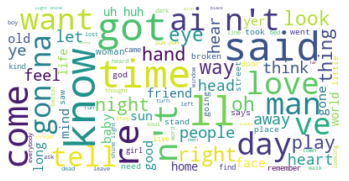

In [496]:
plot_clouds(all_bob)

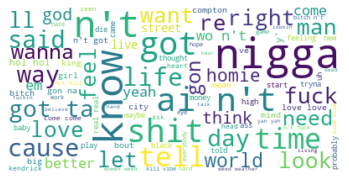

In [495]:
plot_clouds(all_ken)

We can see that the language is quite different between Kendrick and Bob lyrics, but thats understandable and to be expected.

This doens't really tell us anything that we didn't know before.

Lets use text embeddings to properly inspect that seperability of the language.

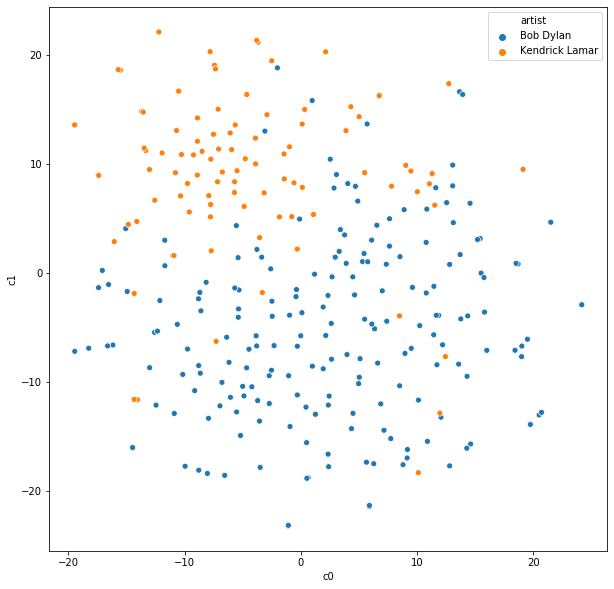

In [529]:
tsne2 = create_text_embeddings(2, X, 25)
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(tsne2['c0'], tsne2['c1'], hue=tsne2['artist']);

There are some bob songs in kendrick territory and vice versa.

Lets take a quick look.

In [530]:
tsne2[(tsne2['c0']>0)&(tsne2['c1']<0)&(tsne2['artist']=='Kendrick Lamar')]

,c0,c1,artist,song
245,12.440882,-7.658236,Kendrick Lamar,​good kid
248,10.113191,-18.283951,Kendrick Lamar,For Sale? (Interlude)
271,11.965561,-12.831423,Kendrick Lamar,​untitled 01 | 08.19.2014.
280,8.493573,-3.928499,Kendrick Lamar,​untitled 06 | 06.30.2014.


The most peripheral is 'For Sale?' lets take a look.

In [543]:
df[df['song']=='For Sale? (Interlude)']['lyrics'].values[0][500:1000]

'rinking that potion, you can see me swerving \'cause i (want you) (i want you more than you know)    i remember you took me to the mall last week, baby you looked me in my eyes about four, five times \'til i was hypnotized, then you clarified that i (want you) you said sherane ain\'t got nothing on lucy i said, "you crazy?" roses are red, violets are blue but me and you both pushing up daisies if i (want you)    now, baby, when i get you, get you, get you, get you i\'ma go hit the throttle with you '

Could be Bob!?

Lets look for the Kendrick-like Bob tracks.

In [544]:
tsne2[(tsne2['c0']<10)&(tsne2['c1']>10)&(tsne2['artist']=='Bob Dylan')]

,c0,c1,artist,song
16,5.706668,13.655292,Bob Dylan,"It’s Alright, Ma (I’m Only Bleeding)"
59,0.978340,15.796454,Bob Dylan,Queen Jane Approximately
124,-3.087412,12.996831,Bob Dylan,Bob Dylan’s Blues
135,2.532752,10.427600,Bob Dylan,Like A Rolling Stone (Video)
138,-2.010780,18.788519,Bob Dylan,Froggie Went A-Courtin’


In [545]:
df[df['song']=='It’s Alright, Ma (I’m Only Bleeding)']['lyrics'].values[0][500:1000]

"an, but unlike before you discover that you'd just be one more person crying    so don't fear if you hear a foreign sound to your ear it's alright, ma, i'm only sighing    as some warn victory, some downfall private reasons, great or small can be seen in the eyes of those that call to make all that should be killed to crawl while others say don't hate nothing at all except hatred    disillusioned words like bullets bark as human gods aim for their mark make everything from toy guns that spark to"

Again, could be Kendrick!

Lets try 3-dimensions and check if the same holds.

In [528]:
tsne3 = create_text_embeddings(3, X, 25)
fig = px.scatter_3d(tsne3, x='c0', y='c1', z='c2',
              color='artist', symbol='artist',  opacity=0.7, size_max=2)
fig.show()

Still the data is seperable - this is promising and as we'd expect.

Lets get to modelling.

## Modelling Functions

In [245]:
def plot_confusion(cm):
    '''
    Generate a confusion matrix
    '''
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,  cmap = 'coolwarm')
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.xticks([i-0.5 for i in range(1,3)], ['Bob Dylan', 'Kendrick Lamar'])
    plt.yticks([i-0.5 for i in range(1,3)], ['Bob Dylan', 'Kendrick Lamar'])
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show()

In [409]:
def generate_class_weights(y):
    '''
    Get class weights to help manage slight class imbalance
    '''
    return dict(zip(list(np.unique(y)), 
                    class_weight.compute_class_weight('balanced', np.unique(y), y)))


## First Model - Random Forest

In [410]:
class_weights = generate_class_weights(df['artist'])

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, df['artist'],
                                                    test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True,
                                                    stratify=df['artist'])

In [412]:
param_grid = {
    
    'n_estimators':[50,100,150,200,250,300],
    'max_depth':[5,7,10,15]
    
}

grid = GridSearchCV(RandomForestClassifier(random_state=1,
                                           class_weight=class_weights),
                                           param_grid,
                                           cv=5,
                                           n_jobs=2).fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

0.95 {'max_depth': 10, 'n_estimators': 50}


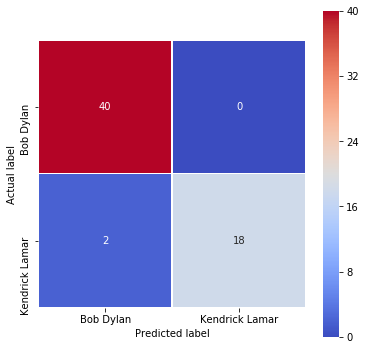

In [413]:
rf = RandomForestClassifier(random_state = 1,
                             max_depth=grid.best_params_['max_depth'],
                             n_estimators=grid.best_params_['n_estimators'],
                             class_weight=class_weights).fit(X_train, y_train)

preds = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

In [388]:
imps = pd.DataFrame({'importance':clf.feature_importances_,
                     'feature':X_train.columns})

imps.sort_values('importance').tail(15)

,importance,feature
248,0.012942,em
496,0.013396,life
24,0.013477,ass
6,0.013720,ai
165,0.014073,compton
91,0.014697,bout
326,0.015054,fuck
62,0.015373,bitch
357,0.017219,got
988,0.018763,yeah


Clearly its easier to identify Kendrick's terms than Bob's!

Lets check where we actually misclassify for our 2 errors.

In [389]:
results = pd.DataFrame({'actual':y_test,
                        'predicted':preds
                        }, index=y_test.index)

results['lyrics'], results['song'] = df['lyrics'], df['song']

In [390]:
mistakes = results[results['actual']!=results['predicted']]

In [391]:
for key, value in dict(zip(list(mistakes['song'].values), list(mistakes['lyrics'].values))).items():
    print('Song: ' + key)
    print('   ')
    print(value)
    print('  ')

Song: Black Panther
   
  (why i go easy?) (know why i go easy) wait    king of my city, king of my country, king of my homeland king of the filthy, king of the fallen, we livin' again king of the shooters, looters, boosters, and ghettos poppin' king of the past, present, future, my ancestors watchin' king of the culture, king of the soldiers, king of the bloodshed king of the wisdom, king of the ocean, king of the respect king of the optimistics and dreamers that go and get it king of the winner's district and geniuses with conviction king of the fighters, king of the fathers, king of the belated king of the answer, king of the problem, king of the forsaken king of the empathy, you resent me, king of remorse king of my enemies, may they fall defeat, i rejoice king of the skyscrapers, dodgin' haters, broke religion    nine faces, go against 'em, i erased 'em with precision i embrace them with collision, kings did it king's vision, black panther, king kendrick, all hail the king! i drop

Not so surprising really! These are both Kendrick tracks but they're missing some of his usual language.

Eyeballing some of the language in both of these tracks, its really not immediately clear who's written them. Thematically, its likely that Black Panther would be a Kendrick track and some of the phrasing in untitled 04 is also quite clearly Kendrick but to a basic model, these features shouldn't really be discernible.

In [337]:
print(classification_report(y_test, preds))

                precision    recall  f1-score   support

     Bob Dylan       0.95      1.00      0.98        40
Kendrick Lamar       1.00      0.90      0.95        20

     micro avg       0.97      0.97      0.97        60
     macro avg       0.98      0.95      0.96        60
  weighted avg       0.97      0.97      0.97        60



As we gauged from the confusion matrix, our accuracy, precision and recall were all strong.

## Second Model - Logistic Regression

0.9375 {'C': 0.9111627561154896, 'penalty': 'l2'}


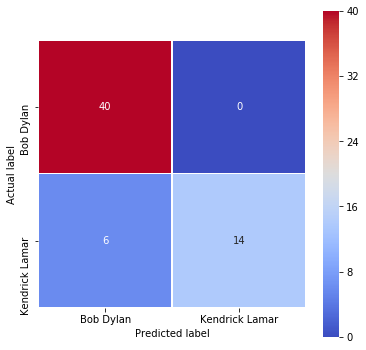

In [433]:
'''
Logistic Regression
'''

param_grid = {
    
    'C':np.logspace(-4,4,100),
    'penalty':['l1','l2']
    
}

grid = GridSearchCV(LogisticRegression(random_state=1, solver = 'saga',
                                           class_weight=class_weights),
                                           param_grid,
                                           cv=5,
                                           n_jobs=2).fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

logreg = LogisticRegression(random_state = 1, solver = 'saga',
                             C=grid.best_params_['C'],
                             penalty=grid.best_params_['penalty'],
                             class_weight=class_weights).fit(X_train, y_train)

preds = clf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

## Third Model - Modelling phrases instead of songs

The task in the above is too easy. To train our model well, we need to toughen it up.

Lets create more data by splitting songs into phrases.

In [564]:
df['phrases'] = df['lyrics'].str.split('  ').apply(lambda x: list(filter(None, x)))

In [604]:
phrases = (df['phrases'].apply(pd.Series)
              .stack()
              .reset_index(level=1, drop=True)
              .to_frame('phrases'))

In [609]:
phrases = pd.merge(phrases,
         df[['artist', 'song', 'lyrics']],
         left_index=True,
         right_index=True,
         how='left').reset_index(drop=True)

In [614]:
pos = ['NOUN', 'ADJ', 'VERB', 'ADV']

phrases['lyrics'] = phrases.lyrics.str.replace('\n',' ')\
                            .apply(lambda x: drop_breaks(x))\
                            .apply(lambda x: remove_digits(x))\
                            .str.lower()

processed_quotes_phrase, tokenised_quotes_phrase = process_text(phrases['phrases'])



In [615]:
phrases['lyrics_processed'] = processed_quotes_phrase
phrases['lyrics_tokenised'] = tokenised_quotes_phrase

In [632]:
phrase_vectoriser, phrases_vector_data=vectorise(ngram_range=(1, 2),
                                                  max_feats=1000,
                                                  input_data=phrases['lyrics_processed'])

In [633]:
class_weights = generate_class_weights(phrases['artist'])

X_train, X_test, y_train, y_test = train_test_split(phrases_vector_data, phrases['artist'],
                                                    test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True,
                                                    stratify=phrases['artist'])

param_grid = {
    
    'n_estimators':[50,100,150,200,250,300,400],
    'max_depth':[5,7,10,15,20]
    
}

grid = GridSearchCV(RandomForestClassifier(random_state=1,
                                           class_weight=class_weights),
                                           param_grid,
                                           cv=5,
                                           n_jobs=2).fit(X_train, y_train)

print('Baseline accuracy: {}'.format(round(y_train.value_counts(normalize=True).max(),3)))
print(grid.best_score_, grid.best_params_)

Baseline accuracy: 0.626
0.8617125984251969 {'max_depth': 20, 'n_estimators': 250}


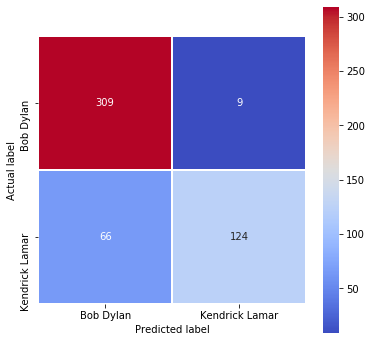

In [634]:
rf_phrase = RandomForestClassifier(random_state = 1,
                             max_depth=grid.best_params_['max_depth'],
                             n_estimators=grid.best_params_['n_estimators'],
                             class_weight=class_weights).fit(X_train, y_train)

preds = rf_phrase.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

## Optimised Model

In [ ]:
def export_models(classification_model, class_model_name, vectoriser, vectoriser_name):
    '''
    Retrieve models for classification and for 
    word vectorising
    '''
    return joblib.dump(classification_model, class_model_name), joblib.dump(vectoriser, vectoriser_name)

## Predict on any user-generated lyrics

In [ ]:
def import_models(classification_model, vectoriser):
    '''
    Retrieve models for classification and for 
    word vectorising
    '''
    return joblib.load(classification_model), joblib.load(vectoriser)

In [425]:
def gather_lyric():
    '''
    Simply asking for an input
    '''
    return input('Try your lyric here: ').lower()


In [426]:
def convert_lyric_to_vector(lyric, vectoriser):
    '''
    Creates predictor observation with vectorised
    weightings
    '''
    return pd.DataFrame(vectoriser.transform([lyric]).todense(), columns=vectoriser.get_feature_names())


In [450]:
def generate_prediction(vectoriser, model, num_preds):
    '''
    Print n predictions for an inputted lyric using
    a given vectoriser and pre-trained model
    '''
    for i in range(num_preds):
        lyric=gather_lyric()
        print('{} probably sang that.'.format(model.predict(convert_lyric_to_vector(lyric, vectoriser))[0]))
        print('_____________________________________________')

In [635]:
generate_prediction(vectoriser, rf_phrase, 5)

Try your lyric here: bob freewheelin all day down the road
Bob Dylan probably sang that.
_____________________________________________
Try your lyric here: heading down to compton
Kendrick Lamar probably sang that.
_____________________________________________
Try your lyric here: im the king round here
Bob Dylan probably sang that.
_____________________________________________
Try your lyric here: up to the clubs
Bob Dylan probably sang that.
_____________________________________________
Try your lyric here: singing all day long
Bob Dylan probably sang that.
_____________________________________________


---